In [7]:
%pip install kagglehub
%pip install tensorflow
%pip install scikit-learn
%pip install pandas 
%pip install seaborn
%python3.9 -m pip install torch 



Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%python3.9` not found.


In [2]:
import kagglehub
import os
path = kagglehub.dataset_download("jtiptj/chest-xray-pneumoniacovid19tuberculosis")

print("Path to dataset files:", path)

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████████████████████████████████| 1.74G/1.74G [26:03<00:00, 1.19MB/s]

Extracting files...


Path to dataset files: /Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1


Epoch [1/10], Train Loss: 0.1941, Val Loss: 0.1245, Train Acc: 0.9341, Val Acc: 0.9474
Epoch [2/10], Train Loss: 0.0873, Val Loss: 0.0312, Train Acc: 0.9701, Val Acc: 1.0000
Epoch [3/10], Train Loss: 0.0755, Val Loss: 0.2621, Train Acc: 0.9757, Val Acc: 0.8684
Epoch [4/10], Train Loss: 0.0568, Val Loss: 0.2530, Train Acc: 0.9799, Val Acc: 0.9211
Epoch [5/10], Train Loss: 0.0447, Val Loss: 0.0302, Train Acc: 0.9842, Val Acc: 1.0000
Epoch [6/10], Train Loss: 0.0434, Val Loss: 0.1196, Train Acc: 0.9844, Val Acc: 0.9211
Epoch [7/10], Train Loss: 0.0329, Val Loss: 0.1894, Train Acc: 0.9896, Val Acc: 0.8684
Epoch [8/10], Train Loss: 0.0272, Val Loss: 0.1837, Train Acc: 0.9911, Val Acc: 0.8947
Epoch [9/10], Train Loss: 0.0206, Val Loss: 0.0254, Train Acc: 0.9924, Val Acc: 0.9737
Epoch [10/10], Train Loss: 0.0475, Val Loss: 0.1768, Train Acc: 0.9825, Val Acc: 0.8947


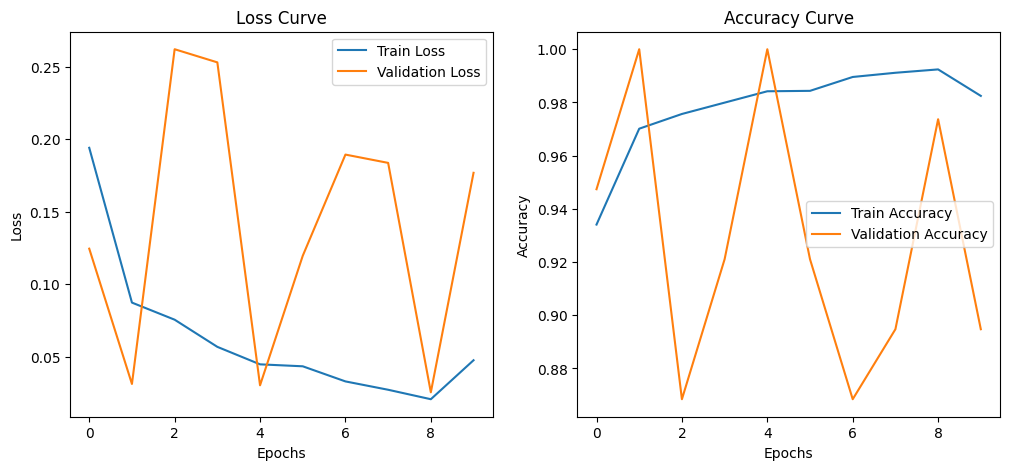

Accuracy: 0.89
Precision: 0.92
Recall: 0.89
F1 Score: 0.89


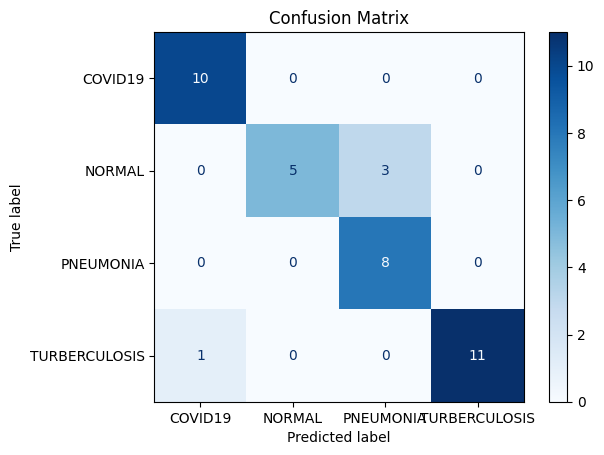

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Define paths
train_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/train'
val_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/val'
test_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/test'

# Define a label mapping for the four classes
label_map = {
    "COVID19": 0,
    "NORMAL": 1,
    "PNEUMONIA": 2,
    "TURBERCULOSIS": 3
}

# Create a custom Dataset class
class ChestXRayDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.filepaths = []
        self.labels = []
        self.transform = transform
        for label in os.listdir(folder_path):
            label_folder = os.path.join(folder_path, label)
            for img_file in os.listdir(label_folder):
                self.filepaths.append(os.path.join(label_folder, img_file))
                self.labels.append(label_map[label])  # Map labels to integers

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and DataLoaders
train_dataset = ChestXRayDataset(train_folder, transform)
val_dataset = ChestXRayDataset(val_folder, transform)
test_dataset = ChestXRayDataset(test_folder, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load ResNet18 model and modify final layer for four classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 4)  # Four classes
model = model.to(device)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on validation set and display confusion matrix with metrics
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calculate confusion matrix and other metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys()))
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


Found 6326 files belonging to 4 classes.
Found 38 files belonging to 4 classes.
Found 771 files belonging to 4 classes.


Model: "functional_44"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_23 (Cast)      │ (None, 224, 224,  │          0 │ input_layer_29[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_12   │ (None, 230, 230,  │          0 │ cast_23[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_1… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_13   │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 12,287,528 (46.87 MB)

 Trainable params: 5,414,056 (20.65 MB)

 Non-trainable params: 6,873,472 (26.22 MB)

Epoch 1/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 158s 389ms/step - accuracy: 0.5333 - loss: 3.5772 - val_accuracy: 0.5263 - val_loss: 1.5681 - learning_rate: 1.0000e-04
Epoch 2/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 151s 380ms/step - accuracy: 0.8256 - loss: 0.4621 - val_accuracy: 0.6579 - val_loss: 1.0833 - learning_rate: 1.0000e-04
Epoch 3/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 150s 380ms/step - accuracy: 0.8494 - loss: 0.3911 - val_accuracy: 0.7105 - val_loss: 0.8067 - learning_rate: 1.0000e-04
Epoch 4/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 155s 391ms/step - accuracy: 0.8712 - loss: 0.3376 - val_accuracy: 0.7632 - val_loss: 0.8667 - learning_rate: 1.0000e-04
Epoch 5/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 154s 388ms/step - accuracy: 0.8860 - loss: 0.3058 - val_accuracy: 0.7895 - val_loss: 0.7807 - learning_rate: 1.0000e-04
Epoch 6/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 150s 379ms/step - accuracy: 0.8981 - loss: 0.2773 - val_accuracy: 0.6579 - val_loss: 0.9878 - learning_rate: 1.0000e-04
Epoch 7/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 

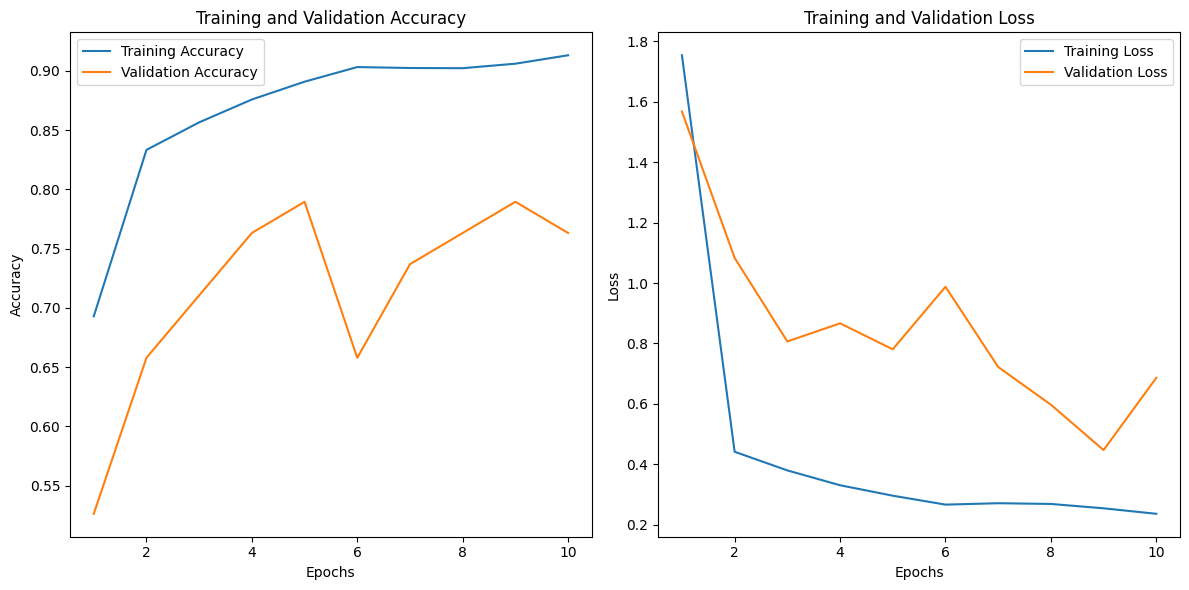

49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step


<Figure size 800x600 with 0 Axes>

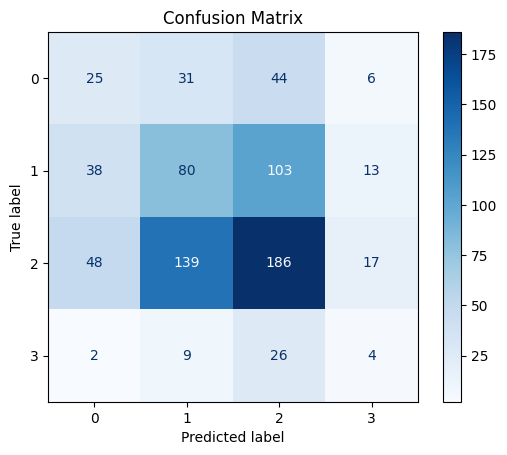

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
'''
# Enable mixed precision for faster training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set up paths for the dataset
train_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/train'
val_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/val'
test_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/test'

# Load datasets with data augmentation and prefetching for efficiency
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

# Training data with augmentation
train_ds = image_dataset_from_directory(
    train_folder,
    image_size=(224, 224),
    batch_size=16,
    shuffle=True
).map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Validation and test data without augmentation
val_ds = image_dataset_from_directory(
    val_folder,
    image_size=(224, 224),
    batch_size=16
).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = image_dataset_from_directory(
    test_folder,
    image_size=(224, 224),
    batch_size=16
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Define DenseNet for feature extraction with fine-tuning
def create_feature_extractor():
    base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze all layers initially

    # Unfreeze the last 10 layers for fine-tuning
    for layer in base_model.layers[-10:]:
        layer.trainable = True

    cnn_output = layers.GlobalAveragePooling2D()(base_model.output)
    return models.Model(inputs=base_model.input, outputs=cnn_output)

# Define LSTM Decoder
def create_lstm_decoder(vocab_size, lstm_units=256):
    input_layer = layers.Input(shape=(None, 2048))
    x = layers.LSTM(lstm_units, return_sequences=True)(input_layer)
    x = layers.LSTM(lstm_units)(x)
    output_layer = layers.Dense(vocab_size, activation='softmax', dtype='float32')(x)  # float32 to maintain precision
    return models.Model(inputs=input_layer, outputs=output_layer)

# Combine DenseNet and LSTM into a complete model
def create_densenet_lstm_model(vocab_size, sequence_length=10):
    cnn_model = create_feature_extractor()

    # Reshape CNN output for LSTM input
    cnn_output = layers.Dense(2048, activation='relu')(cnn_model.output)
    cnn_output = layers.BatchNormalization()(cnn_output)
    cnn_output = layers.Dropout(0.5)(cnn_output)

    lstm_input = layers.RepeatVector(sequence_length)(cnn_output)
    lstm_output = create_lstm_decoder(vocab_size)(lstm_input)

    complete_model = models.Model(inputs=cnn_model.input, outputs=lstm_output)

    # Compile model
    initial_learning_rate = 1e-4
    optimizer = optimizers.Adam(learning_rate=initial_learning_rate)
    complete_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return complete_model

# Instantiate model and set up callbacks
vocab_size = 1000
densenet_lstm_model = create_densenet_lstm_model(vocab_size)
densenet_lstm_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = densenet_lstm_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate on test data
y_pred_prob = densenet_lstm_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred_prob, axis=-1)

# Extract true labels
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

# Calculate metrics
accuracy = accuracy_score(test_labels, y_pred_classes)
precision = precision_score(test_labels, y_pred_classes, average='weighted')
recall = recall_score(test_labels, y_pred_classes, average='weighted')
f1 = f1_score(test_labels, y_pred_classes, average='weighted')

# Adjust ROC AUC for multi-class
try:
    test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=y_pred_prob.shape[-1])
    roc_auc = roc_auc_score(test_labels_one_hot, y_pred_prob, multi_class='ovr')
except ValueError:
    roc_auc = None
    print("ROC AUC Score could not be calculated due to class imbalance.")
'''
# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
if roc_auc:
    print(f'ROC AUC Score: {roc_auc:.2f}')
else:
    print("ROC AUC Score: Not calculated due to class imbalance.")

# Plot training history
def plot_training_history(history):
    epochs_range = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Plot confusion matrix
def plot_confusion_matrix(model, test_ds):
    y_pred_prob = model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_prob, axis=-1)
    test_labels = np.concatenate([y for x, y in test_ds], axis=0)

    cm = confusion_matrix(test_labels, y_pred_classes)
    disp_labels = [str(i) for i in range(len(np.unique(test_labels)))]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(densenet_lstm_model, test_ds)



Training and evaluating resnet18...

Epoch [1/10], Train Loss: 0.2436, Val Loss: 0.7287, Train Acc: 0.9143, Val Acc: 0.7368
Epoch [2/10], Train Loss: 0.1346, Val Loss: 0.2241, Train Acc: 0.9512, Val Acc: 0.8684
Epoch [3/10], Train Loss: 0.1128, Val Loss: 1.0297, Train Acc: 0.9597, Val Acc: 0.7368
Epoch [4/10], Train Loss: 0.0951, Val Loss: 0.3271, Train Acc: 0.9652, Val Acc: 0.7632
Epoch [5/10], Train Loss: 0.0919, Val Loss: 0.3563, Train Acc: 0.9668, Val Acc: 0.7895
Epoch [6/10], Train Loss: 0.0836, Val Loss: 0.3724, Train Acc: 0.9711, Val Acc: 0.7632
Epoch [7/10], Train Loss: 0.0812, Val Loss: 0.1693, Train Acc: 0.9696, Val Acc: 0.8684
Epoch [8/10], Train Loss: 0.0777, Val Loss: 0.1419, Train Acc: 0.9738, Val Acc: 0.8947
Epoch [9/10], Train Loss: 0.0574, Val Loss: 0.3252, Train Acc: 0.9779, Val Acc: 0.8684
Epoch [10/10], Train Loss: 0.0655, Val Loss: 0.1229, Train Acc: 0.9760, Val Acc: 0.9211

Results for resnet18:
Accuracy: 0.85
Precision: 0.87
Recall: 0.85
F1 Score: 0.85


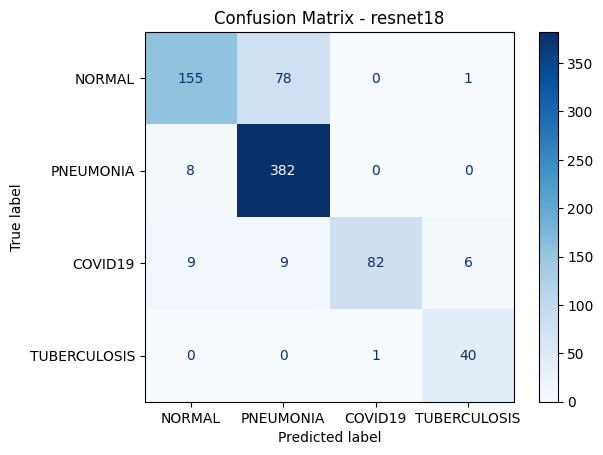


Training and evaluating efficientnet_b0...



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /Users/nishchalnaithani/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████████████████████████████████| 20.5M/20.5M [00:20<00:00, 1.04MB/s]


Epoch [1/10], Train Loss: 0.1944, Val Loss: 0.2204, Train Acc: 0.9353, Val Acc: 0.8684
Epoch [2/10], Train Loss: 0.0888, Val Loss: 0.2151, Train Acc: 0.9701, Val Acc: 0.8421
Epoch [3/10], Train Loss: 0.0683, Val Loss: 0.3785, Train Acc: 0.9758, Val Acc: 0.7632
Epoch [4/10], Train Loss: 0.0729, Val Loss: 0.1745, Train Acc: 0.9771, Val Acc: 0.8947
Epoch [5/10], Train Loss: 0.0547, Val Loss: 0.4106, Train Acc: 0.9804, Val Acc: 0.7632
Epoch [6/10], Train Loss: 0.0400, Val Loss: 0.3638, Train Acc: 0.9859, Val Acc: 0.8684
Epoch [7/10], Train Loss: 0.0372, Val Loss: 0.1597, Train Acc: 0.9886, Val Acc: 0.9474
Epoch [8/10], Train Loss: 0.0474, Val Loss: 0.0433, Train Acc: 0.9825, Val Acc: 0.9474
Epoch [9/10], Train Loss: 0.0440, Val Loss: 0.1586, Train Acc: 0.9837, Val Acc: 0.8947
Epoch [10/10], Train Loss: 0.0331, Val Loss: 0.0884, Train Acc: 0.9862, Val Acc: 0.9211

Results for efficientnet_b0:
Accuracy: 0.88
Precision: 0.90
Recall: 0.88
F1 Score: 0.87


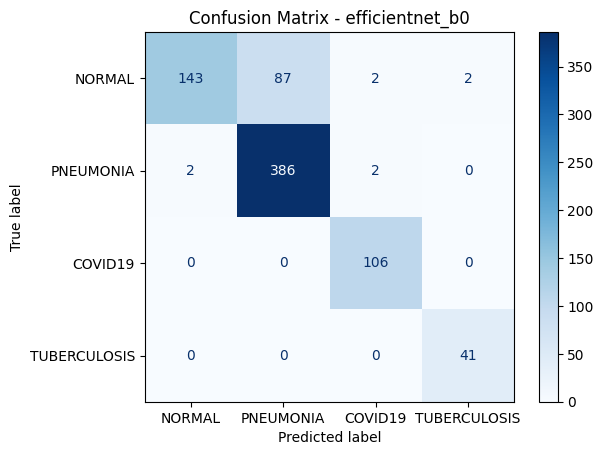


Training and evaluating mobilenet_v2...



Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/nishchalnaithani/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████████████████████████████████| 13.6M/13.6M [00:11<00:00, 1.20MB/s]


Epoch [1/10], Train Loss: 0.2231, Val Loss: 0.4081, Train Acc: 0.9233, Val Acc: 0.7895
Epoch [2/10], Train Loss: 0.1248, Val Loss: 0.5056, Train Acc: 0.9554, Val Acc: 0.8421
Epoch [3/10], Train Loss: 0.1098, Val Loss: 0.1358, Train Acc: 0.9625, Val Acc: 0.9474
Epoch [4/10], Train Loss: 0.0912, Val Loss: 0.1632, Train Acc: 0.9676, Val Acc: 0.8684
Epoch [5/10], Train Loss: 0.0805, Val Loss: 0.1649, Train Acc: 0.9719, Val Acc: 0.9211
Epoch [6/10], Train Loss: 0.0680, Val Loss: 0.6750, Train Acc: 0.9768, Val Acc: 0.7105
Epoch [7/10], Train Loss: 0.0762, Val Loss: 0.0196, Train Acc: 0.9739, Val Acc: 1.0000
Epoch [8/10], Train Loss: 0.0548, Val Loss: 0.2669, Train Acc: 0.9804, Val Acc: 0.8421
Epoch [9/10], Train Loss: 0.0579, Val Loss: 0.0556, Train Acc: 0.9799, Val Acc: 0.9737
Epoch [10/10], Train Loss: 0.0751, Val Loss: 0.2156, Train Acc: 0.9761, Val Acc: 0.8421

Results for mobilenet_v2:
Accuracy: 0.74
Precision: 0.82
Recall: 0.74
F1 Score: 0.67


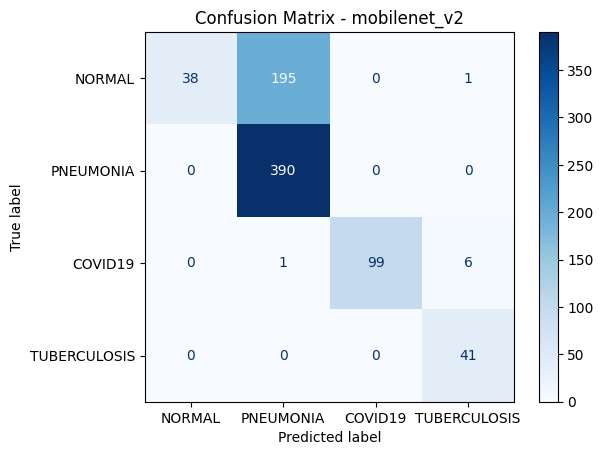

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Define paths for the dataset
train_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/train'
val_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/val'
test_folder = '/Users/nishchalnaithani/.cache/kagglehub/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis/versions/1/test'

class RadiogenDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.class_mapping = {"NORMAL": 0, "PNEUMONIA": 1, "COVID19": 2, "TURBERCULOSIS": 3}

        for label_name, label_index in self.class_mapping.items():
            class_dir = os.path.join(root_dir, label_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory does not exist: {class_dir}")
                continue
            
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                self.image_paths.append(img_path)
                self.labels.append(label_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation and normalization transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = RadiogenDataset(root_dir=train_folder, transform=transform)
val_dataset = RadiogenDataset(root_dir=val_folder, transform=transform)
test_dataset = RadiogenDataset(root_dir=test_folder, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Choose the device
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Define a function to create and return a modified model
def get_model(model_name, num_classes=4):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Model not recognized.")
    return model.to(device)

# List of models to evaluate
models_to_evaluate = ["resnet18", "efficientnet_b0", "mobilenet_v2"]

# Training and evaluation for each model
for model_name in models_to_evaluate:
    print(f"\nTraining and evaluating {model_name}...\n")
    
    # Get model and define loss and optimizer
    radiogen_model = get_model(model_name)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(radiogen_model.parameters(), lr=0.001)
    
    num_epochs = 10
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training and validation loops
    for epoch in range(num_epochs):
        radiogen_model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = radiogen_model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation phase
        radiogen_model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                outputs_val = radiogen_model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    # Testing phase
    y_true, y_pred = [], []
    radiogen_model.eval()
    with torch.no_grad():
        for images_test, labels_test in test_loader:
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            outputs_test = radiogen_model(images_test)
            _, predicted_test = torch.max(outputs_test.data, 1)
            y_true.extend(labels_test.cpu().numpy())
            y_pred.extend(predicted_test.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f'\nResults for {model_name}:')
    print(f'Accuracy: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=["NORMAL", "PNEUMONIA", "COVID19", "TUBERCULOSIS"])
    cmd.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()



Training resnet18...

Epoch [1/10] for resnet18, Train Loss: 0.2263, Val Loss: 0.2807, Train Acc: 0.9192, Val Acc: 0.8684
Epoch [2/10] for resnet18, Train Loss: 0.1416, Val Loss: 0.4352, Train Acc: 0.9483, Val Acc: 0.8421
Epoch [3/10] for resnet18, Train Loss: 0.1312, Val Loss: 0.2278, Train Acc: 0.9537, Val Acc: 0.8684
Epoch [4/10] for resnet18, Train Loss: 0.0991, Val Loss: 0.7067, Train Acc: 0.9665, Val Acc: 0.8158
Epoch [5/10] for resnet18, Train Loss: 0.1026, Val Loss: 0.3875, Train Acc: 0.9647, Val Acc: 0.7895
Epoch [6/10] for resnet18, Train Loss: 0.0843, Val Loss: 0.6215, Train Acc: 0.9704, Val Acc: 0.8684
Epoch [7/10] for resnet18, Train Loss: 0.0628, Val Loss: 0.0944, Train Acc: 0.9772, Val Acc: 0.9211
Epoch [8/10] for resnet18, Train Loss: 0.0722, Val Loss: 0.0793, Train Acc: 0.9757, Val Acc: 0.9474
Epoch [9/10] for resnet18, Train Loss: 0.0649, Val Loss: 0.2726, Train Acc: 0.9798, Val Acc: 0.8158
Epoch [10/10] for resnet18, Train Loss: 0.0654, Val Loss: 0.0708, Train Acc: 

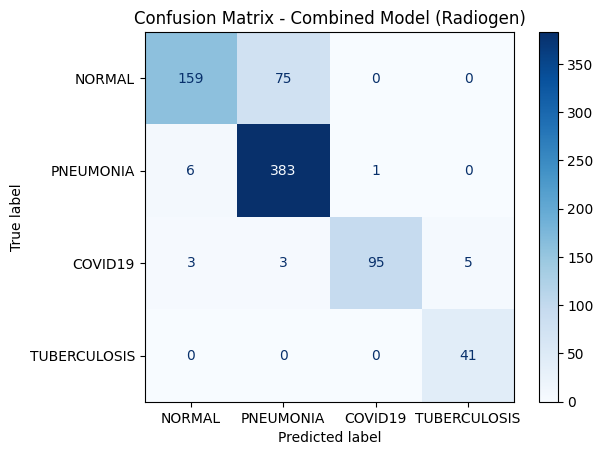

In [43]:
import copy

# Define a function to transfer weights
def transfer_weights(source_model, target_model):
    target_model.load_state_dict(source_model.state_dict(), strict=False)

# List of models for progressive training
model_sequence = ["resnet18", "efficientnet_b0", "mobilenet_v2"]

# Function to get the model (reuse from earlier)
def get_model(model_name, num_classes=4):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "efficientnet_b0":
        model = models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    else:
        raise ValueError("Model not recognized.")
    return model.to(device)

# Training function
def train_and_evaluate(model_name, model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for images_val, labels_val in val_loader:
                images_val, labels_val = images_val.to(device), labels_val.to(device)
                outputs_val = model(images_val)
                loss_val = criterion(outputs_val, labels_val)
                val_loss += loss_val.item()

                _, predicted_val = torch.max(outputs_val.data, 1)
                total_val += labels_val.size(0)
                correct_val += (predicted_val == labels_val).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch [{epoch+1}/{num_epochs}] for {model_name}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return model

# Progressive model training
previous_model = None
for model_name in model_sequence:
    print(f"\nTraining {model_name}...\n")
    
    # Initialize model
    model = get_model(model_name)
    
    # Transfer weights if a previous model exists
    if previous_model:
        transfer_weights(previous_model, model)
    
    # Train the current model
    model = train_and_evaluate(model_name, model, train_loader, val_loader)
    
    # Save the current model as previous for next iteration
    previous_model = copy.deepcopy(model)

# Evaluate the final combined model (Radiogen) on the test set
y_true, y_pred = [], []
previous_model.eval()  # This will be the combined "Radiogen" model
with torch.no_grad():
    for images_test, labels_test in test_loader:
        images_test, labels_test = images_test.to(device), labels_test.to(device)
        outputs_test = previous_model(images_test)
        _, predicted_test = torch.max(outputs_test.data, 1)
        y_true.extend(labels_test.cpu().numpy())
        y_pred.extend(predicted_test.cpu().numpy())

# Calculate performance metrics for the final model
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'\nFinal Combined Model (Radiogen) Results:')
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=["NORMAL", "PNEUMONIA", "COVID19", "TUBERCULOSIS"])
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Combined Model (Radiogen)')
plt.show()


In [54]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image



# Function to create a combined model (Radiogen) with Dropout
def get_combined_model(num_classes=4):
    # Create individual models
    resnet = models.resnet18(pretrained=True)
    resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

    efficientnet = models.efficientnet_b0(pretrained=True)
    efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, num_classes)

    mobilenet = models.mobilenet_v2(pretrained=True)
    mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)

    # Combine models into a custom architecture with Dropout for regularization
    class CombinedModel(nn.Module):
        def __init__(self):
            super(CombinedModel, self).__init__()
            self.resnet = resnet
            self.efficientnet = efficientnet
            self.mobilenet = mobilenet
            self.dropout = nn.Dropout(p=0.5)  # Dropout for regularization
            self.fc = nn.Linear(num_classes * 3, num_classes)  # Final layer to combine outputs

        def forward(self, x):
            # Obtain output from each model
            res_out = self.resnet(x)
            eff_out = self.efficientnet(x)
            mob_out = self.mobilenet(x)
        
            # Concatenate the outputs along the feature dimension
            combined_out = torch.cat((res_out, eff_out, mob_out), dim=1)  # Concatenate along feature dimension
        
            # Apply dropout and pass through the final fully connected layer
            combined_out = self.dropout(combined_out)
            return self.fc(combined_out)

    return CombinedModel().to(device)

# Define transformation for input image (same as training)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Generate vocabulary and tokenizer for report generation
class_mapping = {0: "NORMAL", 1: "PNEUMONIA", 2: "COVID19", 3: "TUBERCULOSIS"}
report_texts = {
    "NORMAL": "The X-ray image shows no signs of abnormality. The lungs appear clear and healthy.",
    "PNEUMONIA": "The X-ray image indicates signs of pneumonia. This condition could cause inflammation and congestion in the lungs.",
    "COVID19": "The X-ray image suggests COVID-19 infection. Common patterns include ground-glass opacities and bilateral involvement.",
    "TUBERCULOSIS": "The X-ray image is consistent with tuberculosis. There may be evidence of granulomas or cavitary lesions in the lungs."
}

# Simple tokenizer
word_to_index = {word: idx for idx, word in enumerate(set(" ".join(report_texts.values()).split()))}
index_to_word = {idx: word for word, idx in word_to_index.items()}
vocab_size = len(word_to_index)

# Instantiate RNN model for report generation
class ReportGeneratorGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=128):
        super(ReportGeneratorGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)  # Output vocabulary size for word prediction

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        output = self.fc(gru_out[:, -1, :])  # Predict only last time step
        return output


def generate_report_gru(predicted_class, report_model):
    words = report_texts[predicted_class].split()
    inputs = torch.tensor([word_to_index[word] for word in words[:-1]], device=device).unsqueeze(0)

    generated_text = words[:]
    
    for _ in range(50):  # Max length of generated text
        outputs = report_model(inputs)
        
        # Apply temperature sampling
        temperature = 0.8
        outputs = outputs / temperature
        probabilities = torch.softmax(outputs, dim=1)
        
        # Sample from the distribution
        predicted_index = torch.multinomial(probabilities, num_samples=1).item()
        predicted_word = index_to_word[predicted_index]
        
        generated_text.append(predicted_word)

        if predicted_word == '.':
            break
        
        # Update inputs for the next word prediction
        predicted_index_tensor = torch.tensor([[predicted_index]], device=device)  # Reshape to [1, 1]
        inputs = torch.cat((inputs, predicted_index_tensor), dim=1)  # Concatenate along sequence dimension
    
    return " ".join(generated_text)


report_model = ReportGeneratorGRU(vocab_size).to(device)

# Function to predict and generate report
def predict_and_generate_report(image_path, model):
    model.eval()
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)

    # Map prediction to class
    predicted_class = class_mapping[predicted.item()]

    # Generate report using RNN
    report = generate_report_gru(predicted_class, report_model)

    print(f"Predicted class: {predicted_class}")
    print("Report:")
    print(report)

# Example usage (uncomment below to use it interactively):
image_path = input("Enter the path of the chest X-ray image: ")
radiogen_model = get_combined_model(num_classes=4)  # Create the combined model once before prediction
predict_and_generate_report(image_path, radiogen_model)

Enter the path of the chest X-ray image:  /Users/nishchalnaithani/.cache/kagglehub/datasets/tolgadincer/labeled-chest-xray-images/versions/1/chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg


Predicted class: NORMAL
Report:
The X-ray image shows no signs of abnormality. The lungs appear clear and healthy. shows This condition healthy. include lungs consistent There indicates patterns granulomas involvement. indicates granulomas abnormality. lungs with Common shows appear cause lesions condition is X-ray may abnormality. lungs indicates Common be image of of with pneumonia. be tuberculosis. The or evidence is may bilateral or This clear suggests condition and
